<a href="https://colab.research.google.com/github/Huertas97/GenAI-FashionMNIST/blob/main/notebooks/AHG_GenAI_FashionMNIST_Conditional_UNet_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GenAI FashionMNIST Challenge



*   Author: Álvaro Huertas García
*   Contact:
  * GitHub: [Huertas97](https://github.com/Huertas97)
  * Gmail: ahuertasg01@gmail.com



Reference List of Sources used:

- https://wandb.ai/capecape/train_sd/reports/How-to-Train-a-Conditional-Diffusion-Model-from-Scratch--VmlldzoyNzIzNTQ1

- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb

- https://github.com/zalandoresearch/fashion-mnist

- https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/

## Outline

- Overview
- Setup
- FashionMNIST Dataset Analysis

## Overview

In this Notebook I am going to:
*  explore the FashionMNIST dataset
*  create **from scratch** and train a class-conditioned UNet model using Pytorch and Diffuser library from HuggingFace
* Evaluate the model using MSE loss
* Test the conditioned generation capabilities of the model

### **What is UNet?**

Something to make clear is the distintion of UNet model, and diffusion process.

UNet is a deep neural network model that was originally introduced in the computer vision field initially for image segmentation, specifically biomedical images ([Paper Link](https://arxiv.org/abs/1505.04597)).

The architecture of UNet conssits of a symmetric architecture with convolutional and pooling layers for downsampling, and then upsampling the image, with skip connections between the symmetric layers. In other words, UNet is an image autoencoder.

On the other hand, Diffusion, that are commonly find in the literatue as "Diffusion models", englobe models that gradually add noise to the original data in the forward diffusion process and then learning to remove the noise in the reverse diffusion process, also named denoising.

UNet can belong to the "diffusion models" category as it can be trained using the diffusion approach to exploit the latent variable extraction autoencoder capabilities of UNet architecture to predict noise of a image, and iteratively remove it to obtain after certain number of step a denoised generated image.
<br>

### **What is a conditional UNet model?**

Solely UNet model are unconditioned models as they do not include any other information during the training/inference phase, as they just provide the expected noise of an image that can be removed form an original noisy image untill finally obtaining the generated image. So this process lacks of guidance or control just relying on the input noisy image.

However, Conditional UNet is a variant of the UNet model that incorporates additional conditional information into the network, so we can explit the capability of adding information during the denoising process where we expect the model to learn how to predict noise to be removed conditioned to the information passed alongside an input image.

In our case, the information will be the class label of the FashionMNIST. Thus, the Conditonal UNet model can be controlled to create a image of an specified class.



Btw: If our scenario required conditioning the output image, with an image instead of the class label, we could have use ControlNet.

Once we have a bit background and organized our ideas, let's jupm to the fun part of coding.


## Notebook Setup

In [51]:
%pip install -qq diffusers icecream

In [156]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
from collections import Counter
from icecream import ic
ic.configureOutput(prefix='DEBUG -> ')


device = 'mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

Using device: cpu


## FashionMNIST Dataset Analysis


FashionMNIST consists of clothes images assigned to one of the following labels ([GitHub Link](https://github.com/zalandoresearch/fashion-mnist)):

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

In [3]:
import matplotlib.pyplot as plt
import torchvision
from torch.utils.data import DataLoader

# Load the dataset
dataset = torchvision.datasets.FashionMNIST(root="fashionmnist/",
                                            train=True,  # download the train split
                                            download=True,
                                            transform=torchvision.transforms.ToTensor())


# Show info about dataset
dataset

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: fashionmnist/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [141]:
# Create a exploratory dataloader (batch size 8 for showing 8 images)
eda_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# Class names for FashionMNIST
class_labels_names = ["T-shirt/top", "Trouser", "Pullover",
                "Dress", "Coat", "Sandal", "Shirt", "Sneaker",
                "Bag", "Ankle boot"]

# Loop through the dataset, collect: image n channels, height and witdh, labels
labels = []
image_sizes = []
image_n_channels = []
color_distributions = []
for image, label in tqdm(dataset, desc="Loading labels and extracting images"):
    # RGB channels
    image_n_channels.append(image.shape[0])

    # Resolution
    image_sizes.append((image.shape[1], image.shape[2]))

    # Labels
    labels.append(label)

    # Color distribution scaled of the image
    pixel_values = (image * 255).flatten().numpy().astype(int)
    color_distribution = np.bincount(pixel_values, minlength=256)
    color_distributions.append(color_distribution)

## Version with comprehension list
# dataset_info = [(image.shape[0], (image.shape[1], image.shape[2]), label) for image, label in
#                 tqdm(dataset, desc="Dataset looping")]
# image_n_channels, image_sizes, labels = zip(*dataset_info)

print(f"Distribution of number of RGB Channels: {Counter(image_n_channels)}")
print(f"Distribution of Resolution (image size in px): {Counter(image_sizes)}")
print(f"Distribution of labels: {Counter(labels)}\n")

Loading labels and extracting images:   0%|          | 0/60000 [00:00<?, ?it/s]

Distribution of number of RGB Channels: Counter({1: 60000})
Distribution of Resolution (image size in px): Counter({(28, 28): 60000})
Distribution of labels: Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})



* We have a dataset of 60,000 images, each with a resolution of 28x28px and a single RGB channel.

* The images are divided into 10 classes, with each class represented uniformily by 6k instances.

For the sake of showing some visualization, even thogh we have gathered the most important details about the dataset, we are going to proceed with some visualization that could be useful for other complex datasets.

#### Visualize images in the dataset with the labels

Here we will see the size (pixels), and the RGB channels of the images.

Image input shape: torch.Size([8, 1, 28, 28])
Labels: [3 0 8 1 0 0 0 2]


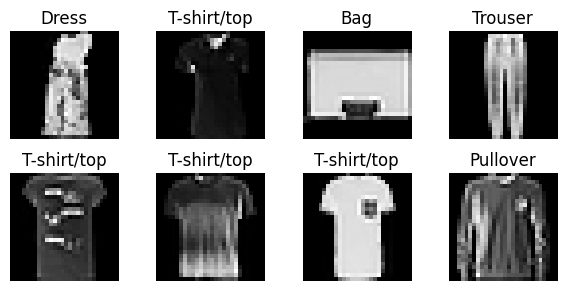

In [90]:
# Get examples from the dataloader
x, y = next(iter(eda_dataloader))
print('Image input shape:', x.shape) # [batch, RGB channels, height, witdh]
print('Labels:', y.detach().numpy())

# Create a grid of images with their labels
fig, axs = plt.subplots(2, 4, figsize=(6, 3))
for i, (img, label) in enumerate(zip(x, y)):
    ax = axs[i // 4, i % 4]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(class_labels_names[label.item()])
    ax.axis('off')

plt.tight_layout()
plt.show()

#### Plotting Histogram of Image Sizes

Here we check visually all the images have the same size (28x28px = 784 px).

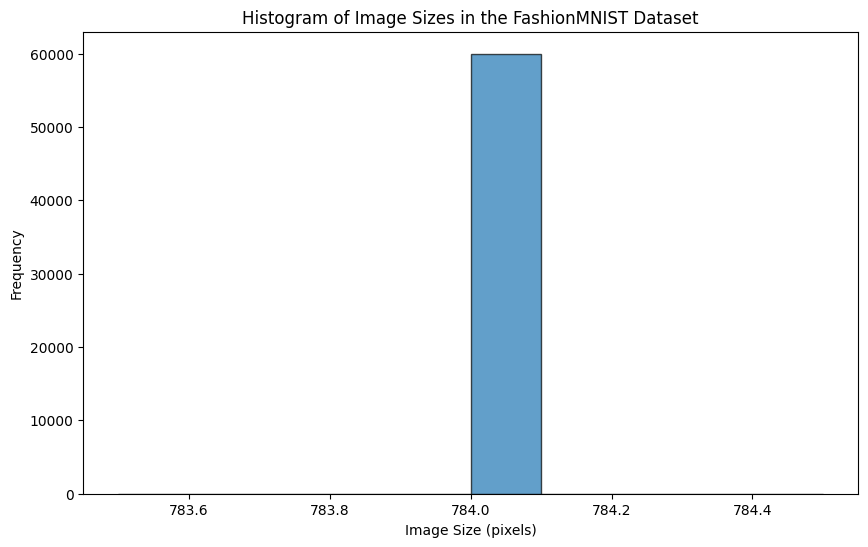

In [33]:
# Extract image sizes (all 28x28 for FashionMNIST)
image_sizes = [image.shape[1] * image.shape[2] for image, _ in dataset]

# Plotting histogram of image sizes
plt.figure(figsize=(10, 6))
plt.hist(image_sizes, bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Image Size (pixels)')
plt.ylabel('Frequency')
plt.title('Histogram of Image Sizes in the FashionMNIST Dataset')
plt.show()

#### Visualizing the Distribution of Images

Visually checking that there is no imbalance, as all classes have 6.000 data instances.

The imbalanced distribution can affect on how the conditional UNet model struggle to generate some classes intead of another.

In case it was imbalanced, we would need to consider some techcniques for helping the model to equitative learn across all the classes (e.g. oversampling, undersampling, weighted loss).

In [114]:
# Visualize the distribution of images in the dataset

# Prepare the x (class names) and y (frequency) data to plot
labels_sorted, freq = zip(*(Counter(labels)).items()) # sorted by Counter
class_labels_sorted = [class_labels[i] for i in labels_sorted] # from int to class name

# Plotly figure
fig = go.Figure()

fig.add_trace(go.Bar(
    x=class_labels_sorted,
    y=freq,
    marker_color='royalblue'
))

fig.update_layout(
    title='Distribution of Images in the FashionMNIST Dataset',
    xaxis_title='Class',
    yaxis_title='Frequency'
)

fig.show() # in GitHub it will not be displayed

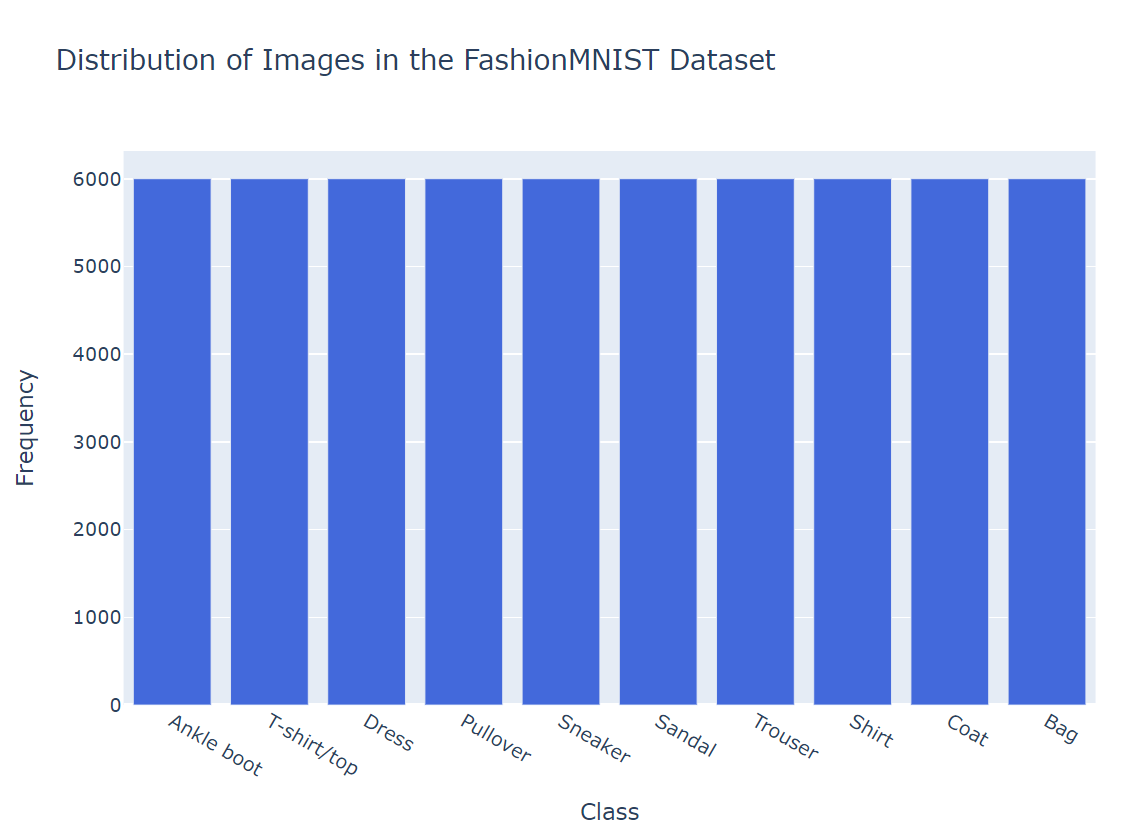

#### Scatter Plot of Image Resolutions

We already know that all images are 28x28 px. However with this code we would make a scatterplot to check it visually.

Honestly, it would be most usefull in a more complex dataset where images have different sizes. Then, we would know how to sclae them to mantain an uniform size across all the dataset to be fed into the model.

In [121]:
import plotly.express as px

# Create a scatter plot for image resolutions
fig = px.scatter(x=np.array(image_sizes)[:, 0], y=np.array(image_sizes)[:, 0],
                 labels={'x': 'Width (pixels)', 'y': 'Height (pixels)'},
                 title='Scatter Plot of Image Resolutions in the FashionMNIST Dataset')

fig.show()

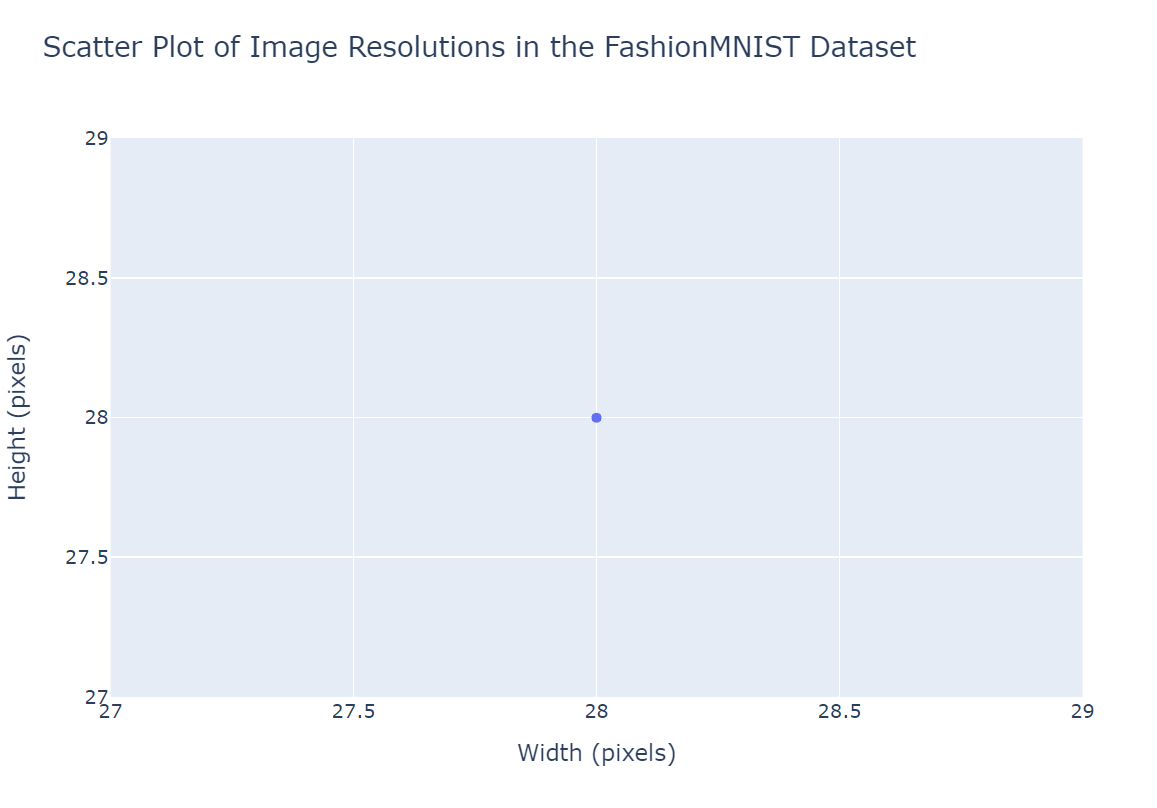

#### Mean Color Distribution

In [155]:
# Mean color distribution of the images of the dataset
fig = px.bar(x=np.arange(256), y=np.mean(color_distributions, axis=0),
             labels={'x': 'Pixel Intensity', 'y': 'Frequency'},
             title='Mean Color Distribution of the Dataset (one RGB channel)')

fig.show()

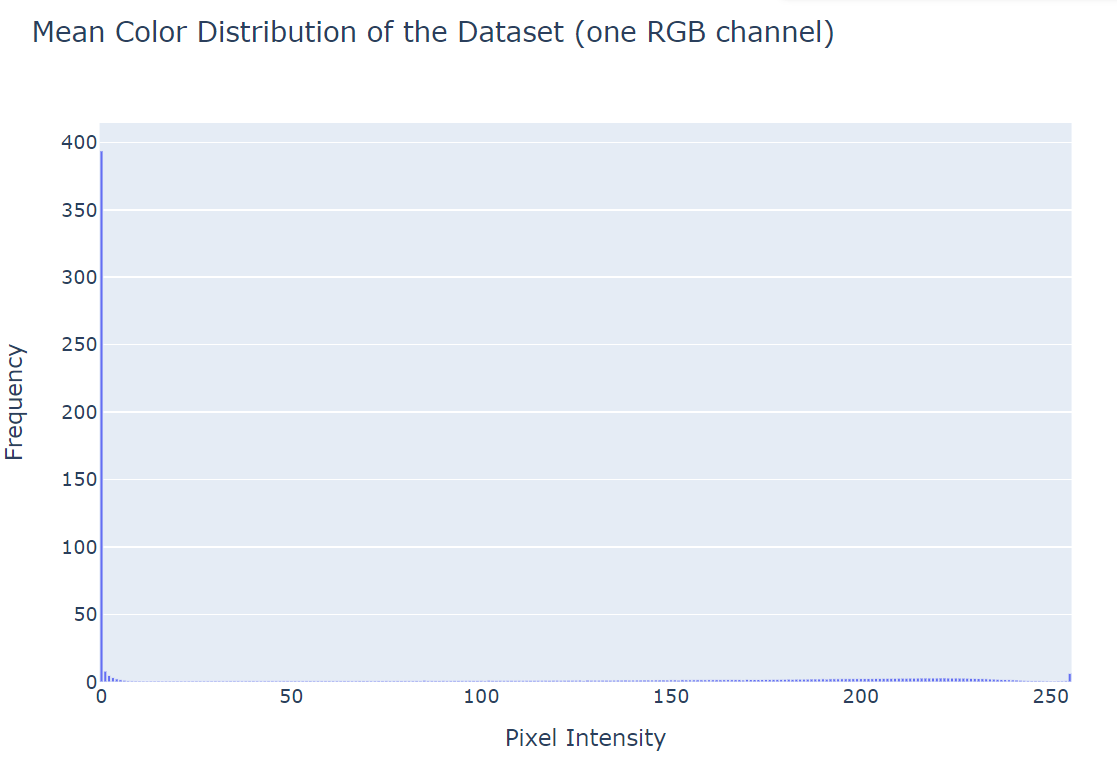

## UNet Implementation (conditional UNet)